## London Air quality and the impact of Ultra Low Emission Zones

Air quality  can have a very big impact on health, and as part of the strategy to clear up the air, London has implemented [Ultra Low Emission Zones](https://tfl.gov.uk/modes/driving/ultra-low-emission-zone) (ULeZ) to help reduce vehicle pollution. Since the scheme is scheduled to expand more in August 2023, it would be interesting to investigate how London's air quality is changing and how this ties in with the ULEZ. It would also be interesting to analyse, if time, how the worst polluting areas overlaps with population densities. 

#### This analysis will aim to:
1. highlight how the air quality is changing over the years by region 
2. can we relate the effectiveness of ULeZ to these changes?
3. Would it be possible to calculate an 'impact' score of the pollution by overlaying population data onto the air quality data?

#### Data set Notes
- The London Data Store has a large set of air quality  monitoring data available at https://data.london.gov.uk/air-quality/ for different years (2019, 2016, 2013). I would expect there to be geospatial data related to air quality along different roads/road sections, as well as data related to the overall measurements of certain pollutants such as nitric oxides in different boroughs. 
- The boundaries for the ULez is available from https://data.london.gov.uk/dataset/ultra_low_emissions_zone (as shapefiles, which would enable easy mapping). One point to note is that this dataset is only available for the 'current' time so I would need to research more about whether there had been any previous ULeZ expansions/area changes.
- the population from 2021 census is available at https://www.ons.gov.uk/filters/b9532b29-299e-4a23-9fc8-b99d68e172b9/dimensions-- also note that I have a previous prototype at https://github.com/wwymak/geo-demos/blob/main/population_2021.ipynb to analyse the 2021 census which I can reuse here
- the data used for pollutant concentrations are from https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/173ed1c2-26c4-4286-96d8-12da40a0c94f/LAEI2019-Concentrations-Data-ASCII.zip, https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2016/924b02c9-bc9c-4fb4-b3aa-0783b9fd84e8/LAEI_2016_Concentrations_Data_ASCII.zip, (unzipped into folders (2019-concentration-data-gis, 2016-concentration-data-gis))



### Data Exploration

In [2]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
from tqdm import tqdm
import fiona
import rasterio as rio
import matplotlib.pyplot as plt

from typing import Tuple

The first look will be on the 2019 data, as this is the most current. 

The first dataset is the concentrations of different pollutants. According to the datastore site, this is:

> Concentrations: This dataset includes modelled 2019 ground level concentrations of annual mean NOx, NO2, PM10 and PM2.5 in µg/m3 (microgramme per cubic metre) at 20m grid resolution. For PM10, it also includes the number of daily means exceeding 50 µg/m3. Data are provided in CSV, GIS (ESRI) and PDF formats.

In [4]:
# we will work with the ASCII files, as these are easily handled with rasterio and can be manipulated as np arrays
conc_nox_2019_dataset = rio.open('data/2019-concentration-data-gis/ASCII/laei_LAEI2019v3_CorNOx15_NO2.asc')
conc_nox_2019_data = conc_nox_2019_dataset.read()

In [5]:
print(f"array shape:{conc_nox_2019_data.shape}")
print(f"no data value: {conc_nox_2019_dataset.get_nodatavals()}")
print(f"data max value: {conc_nox_2019_data.max()}")

array shape:(1, 2555, 3026)
no data value: (-9999.0,)
data max value: 2320.027099609375


Since the data has only 1 band (rasters have the 'bands' in the 1st dimension of the array), we can reduce the data to a 2d array. We would also need to handle the '-9999' no data value squares

In [6]:
# remove first dimension
conc_nox_2019_data = conc_nox_2019_data.squeeze()

In [7]:
# we can see that a large proprtion of cells do have data
cleaned_data_rows, cleaned_data_cols = np.nonzero(conc_nox_2019_data != conc_nox_2019_dataset.get_nodatavals())
valid_cells_count = conc_nox_2019_data[(cleaned_data_rows, cleaned_data_cols)].shape[0]
overall_cells_count = conc_nox_2019_data.flatten().shape[0]

print(f"{valid_cells_count} out of {overall_cells_count} cells, i.e. {np.around(valid_cells_count/overall_cells_count,decimals=2)} in our raster have data")

5851964 out of 7731430 cells, i.e. 0.76 in our raster have data


In [8]:
# in order to plot the concentrations, we need to know what's a 'sensible' range for our data
print('mean nox concentration levels, 2019')
print(np.mean(conc_nox_2019_data[(cleaned_data_rows, cleaned_data_cols)]))
print('median nox concentration levels, 2019')
print(np.median(conc_nox_2019_data[(cleaned_data_rows, cleaned_data_cols)]))

mean nox concentration levels, 2019
24.48307
median nox concentration levels, 2019
23.358894


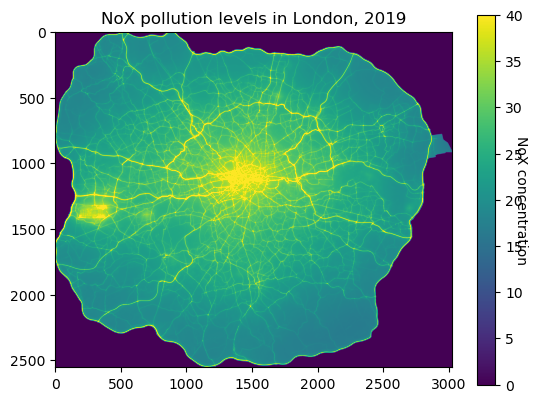

In [9]:
plt.imshow(np.clip(conc_nox_2019_data, a_min=0, a_max=np.inf), vmin=0, vmax=40)
plt.title('NoX pollution levels in London, 2019')
plt.colorbar().set_label('NoX concentration', rotation=270);

Unsurprisingly, the worst places are along the road network-- althoughg you can also spot a big yellow spot in West London (likely to be Heathrow)

### Changes over the years

In [9]:
def process_raster(input_filepath: str) -> tuple((np.array, float, float, float)):
    f"""read in a raster dataset, returning the 2d np array of values, median of valid values, 
    max of valid values and and no data value"""
    
    dataset = rio.open(input_filepath)
    data = dataset.read(1)
    no_data_val = dataset.get_nodatavals()
    rows, cols = np.nonzero(data != dataset.get_nodatavals()[0])
    valid_cells = data[(rows, cols)]
    
    return data, np.median(valid_cells), np.max(valid_cells), no_data_val

In [10]:
conc_nox_2016_data, conc_nox_2016_median, conc_nox_2016_max, conc_nox_2016_nodataval = process_raster(
    '2016-concentration-data-gis/ASCII/LAEI2016_2016_NOx.asc'
)

In [11]:
print(f"in 2016, the median NoX conc is {np.round(conc_nox_2016_median)} and max {np.max(conc_nox_2016_max)}")

in 2016, the median NoX conc is 48.0 and max 6171.47607421875


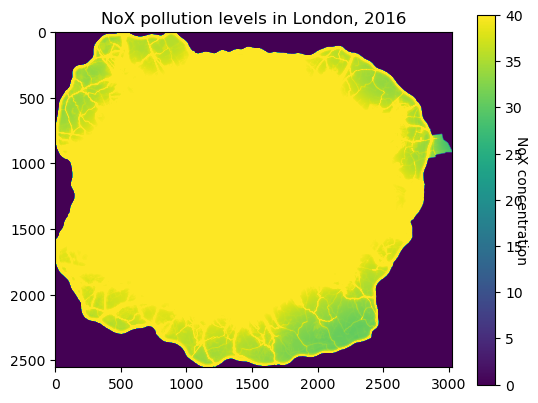

In [12]:
# using the same scales as the above 2019 plot, you can see that the concentration has dropped
plt.imshow(np.clip(conc_nox_2016_data, a_min=0, a_max=np.inf), vmin=0, vmax=40)
plt.title('NoX pollution levels in London, 2016')
plt.colorbar().set_label('NoX concentration', rotation=270);

#### ToDos
- map the changes in percentage concentration per grid cell for all pollutants, not just NoX
- analyse the changes in pollutants both in and outside of ULeZ-- is ULeZ helping to reduce pollutant levels or is the air getting cleaner
- overlay the population data and figure out if it is possible to calculate an impact score, e.g. number of people affect by low/medium/high pollution level
- other questions such as how traffic has changed in London and how they relate to pollutants, and whether changes in types of vehicles have impact